## Simultaneous Reconstruction of Electrostatic and Magnetic Phase Contributions

In this tutorial, we use two sets of far-field diffraction intensities to jointly reconstruct the electrostatic and out-of-plane magnetic vector potential of a crystalline sample described by the Aharonov-Bohm phase shift:

$$
\begin{aligned}
    \phi(\boldsymbol{r}_\bot) &= \phi_e(\boldsymbol{r}_\bot)+\phi_m(\boldsymbol{r}_\bot) \\
    &= \frac{e}{\hbar v}\int_L V(\boldsymbol{r}_{\bot},z) dz -\frac{e}{\hbar}\int_L\boldsymbol{A}(\boldsymbol{r}_{\bot},z)\cdot d\boldsymbol{r}
\end{aligned}
$$

Since the phases enter the multislice transmission function as follows:

$$
\begin{aligned}
T &= \exp{\left[-i \sigma V(r)\right]} \times \exp{\left[-i A(r)\right]} \\
  &= \exp{\left[-i \sigma \left[ V(r) + A(r)/\sigma \right]\right]}
\end{aligned}
$$

we will 'hijack' the `PotentialArray` object to model a dummy magnetic vector potential.  
_Note:_ we'll need to divide by the interaction parameter $\sigma$, to ensure this works properly.

For the electrostatic potential, we will use the same (thin) slab of [110] STO:

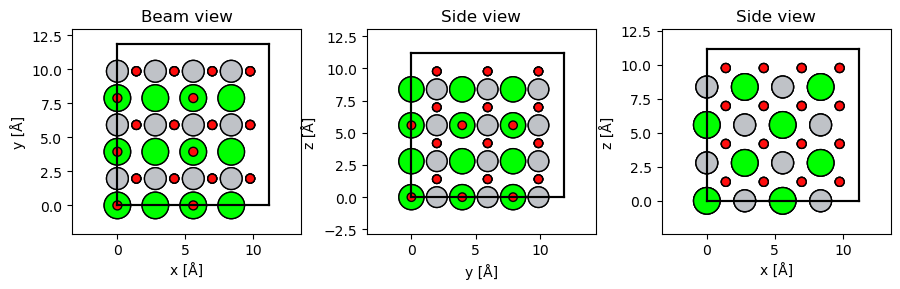

In [1]:
from ase.io import read
from ase import Atoms
from ase.build import surface
from matplotlib import pyplot as plt

from abtem import FrozenPhonons, Potential
from abtem import CTF, Probe

STO_unit_cell = read("../data/SrTiO3.cif")
STO_atoms = surface(STO_unit_cell, (1, 1, 0), 4, periodic=True) * (2, 3, 1)

electrostatic_potential = Potential(
    STO_atoms,
    sampling=0.02,
    device="gpu",
    projection="infinite",
    parametrization="kirkland",
).build()

ctf = CTF(
    parameters={"C10": -75, "C12": 20, "phi12": 0.785, "C30": -7e4}, semiangle_cutoff=24
)
probe = Probe(semiangle_cutoff=24, energy=200e3, ctf=ctf, device="gpu")

probe.match_grid(electrostatic_potential)

from abtem import show_atoms

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3))

show_atoms(STO_atoms, ax=ax1, title="Beam view")
show_atoms(STO_atoms, ax=ax2, plane="yz", title="Side view")
show_atoms(STO_atoms, ax=ax3, plane="xz", title="Side view")

fig.tight_layout();

For the dummy magnetic vector potential, we'll use two gaussians with opposite sign and asymmetric amplitudes:

In [2]:
import cupy as cp
import numpy as np
from cupyx.scipy.special import erf
from abtem.measure import Calibration, Measurement


def projected_gaussian_potential(
    x, y, z0=10.0, z1=0.0, l=10.0, w=10.0, t=10.0, sigma=1.0, asymmetry=2.0
):
    return (
        asymmetry
        * (
            cp.exp(-((w - 4 * y) ** 2 + (l - 4 * x) ** 2) / (32 * sigma**2))
            * (
                erf((t - 4 * z0) / (4 * cp.sqrt(2) * sigma))
                - erf((t - 4 * z1) / (4 * cp.sqrt(2) * sigma))
            )
        )
        + (
            cp.exp(
                -(
                    9 * l**2
                    + 9 * w**2
                    - 24 * l * x
                    - 24 * w * y
                    + 16 * (x**2 + y**2)
                )
                / (32 * sigma**2)
            )
            * (
                erf((4 * z0 - 3 * t) / (4 * cp.sqrt(2) * sigma))
                - erf((4 * z1 - 3 * t) / (4 * cp.sqrt(2) * sigma))
            )
        )
    ) / (4 * asymmetry * cp.pi * sigma**2)


def match_grid(potential):
    gx, gy = potential.gpts
    lx, ly = potential.extent

    return cp.meshgrid(
        cp.linspace(0.0, lx, gx, endpoint=False),
        cp.linspace(0.0, ly, gy, endpoint=False),
        indexing="ij",
    )


def get_cumulative_thicknesses(potential):
    return np.flipud(np.cumsum(np.insert(potential.slice_thicknesses, 0, 0)))


projected_gaussian_calibrations = tuple(
    Calibration(0.0, d, "Å", name, endpoint=False)
    for name, d in zip(("x", "y"), electrostatic_potential.sampling)
)

x, y = match_grid(electrostatic_potential)
l, w, t = STO_atoms.cell.lengths()
projected_gaussian_measurement = Measurement(
    projected_gaussian_potential(
        x, y, z0=t, z1=0, l=l, w=w, t=t, sigma=1.0, asymmetry=2.0
    ),
    projected_gaussian_calibrations,
)

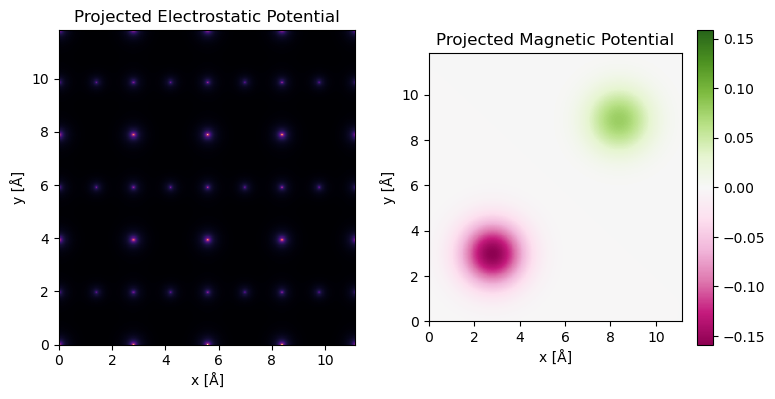

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

electrostatic_potential.project().show(
    cmap="magma", figsize=(4, 4), title="Projected Electrostatic Potential", ax=ax1
)

cmin = np.amin(projected_gaussian_measurement.array)
projected_gaussian_measurement.show(
    cmap="PiYG",
    cbar=True,
    vmin=cmin,
    vmax=-cmin,
    figsize=(4, 4),
    title="Projected Magnetic Potential",
    ax=ax2,
)
fig.tight_layout()

In [4]:
from abtem.utils import energy2sigma

cumulative_thicknesses = get_cumulative_thicknesses(electrostatic_potential)
magnetic_potential = cp.empty(electrostatic_potential.array.shape)

for slice_id in range(electrostatic_potential.num_slices):
    magnetic_potential[slice_id] = projected_gaussian_potential(
        x,
        y,
        z0=cumulative_thicknesses[slice_id],
        z1=cumulative_thicknesses[slice_id + 1],
        l=l,
        w=w,
        t=t,
        sigma=1.0,
        asymmetry=2.0,
    )

magnetic_potential /= energy2sigma(probe.energy)

We'll perform two additional 4DSTEM simulations:
1. One with a positive magnetic vector potenial ('measurement_forward')
2. One with a negative magnetic vector potential ('measurement_reverse')

In [5]:
from abtem.detect import AnnularDetector, PixelatedDetector
from abtem.scan import GridScan
from abtem.noise import poisson_noise

pixelated_detector = PixelatedDetector(max_angle=120)
gridscan = GridScan(
    (0, 0), electrostatic_potential.extent, sampling=0.9 * probe.ctf.nyquist_sampling
)

modified_potential_forward = electrostatic_potential.copy()
modified_potential_forward._array += magnetic_potential

measurement_forward = probe.scan(
    gridscan, pixelated_detector, modified_potential_forward
)
measurement_forward = poisson_noise(measurement_forward, 1e7)

modified_potential_reverse = electrostatic_potential.copy()
modified_potential_reverse._array -= magnetic_potential

measurement_reverse = probe.scan(
    gridscan, pixelated_detector, modified_potential_reverse
)
measurement_reverse = poisson_noise(measurement_reverse, 1e7)

Scan:   0%|          | 0/2350 [00:00<?, ?it/s]

Scan:   0%|          | 0/2350 [00:00<?, ?it/s]

In theory, we could do two independent Regularized-PIE reconstructions for `measurement_forward` and `measurement_reverse` and then use the following relationship to separate the electrostatic and magnetic phase contributions:

$$
\begin{aligned}
\phi_e &= \left(\phi^{(\mathrm{forward})} + \phi^{(\mathrm{reverse})}\right)/2 \\
\phi_m &= \left(\phi^{(\mathrm{forward})} - \phi^{(\mathrm{reverse})}\right)/2
\end{aligned}
$$

In [6]:
from abtem.reconstruct import RegularizedPtychographicOperator

forward_measurement_ptycho_operator = RegularizedPtychographicOperator(
    measurement_forward,
    semiangle_cutoff=24,
    energy=200e3,
    device="gpu",
    parameters={"object_px_padding": (0, 0)},
).preprocess()

(
    forward_objects,
    forward_probes,
    forward_positions,
    forward_sse,
) = forward_measurement_ptycho_operator.reconstruct(
    max_iterations=10,
    verbose=True,
    random_seed=1,
    return_iterations=True,
    parameters={
        "pure_phase_object_update_steps": forward_measurement_ptycho_operator._num_diffraction_patterns
        * 5
    },
)

reverse_measurement_ptycho_operator = RegularizedPtychographicOperator(
    measurement_reverse,
    semiangle_cutoff=24,
    energy=200e3,
    device="gpu",
    parameters={"object_px_padding": (0, 0)},
).preprocess()

(
    reverse_objects,
    reverse_probes,
    reverse_positions,
    reverse_sse,
) = reverse_measurement_ptycho_operator.reconstruct(
    max_iterations=10,
    verbose=True,
    random_seed=1,
    return_iterations=True,
    parameters={
        "pure_phase_object_update_steps": reverse_measurement_ptycho_operator._num_diffraction_patterns
        * 5
    },
)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 23500 steps
--Probe correction is enabled
--Reconstructed object will be constrained to a pure-phase object for the first 11750 steps


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0 , SSE = 2.306e-06
----Iteration 1 , SSE = 5.643e-07
----Iteration 2 , SSE = 5.001e-07
----Iteration 3 , SSE = 4.861e-07
----Iteration 4 , SSE = 4.716e-07
----Iteration 5 , SSE = 3.942e-07
----Iteration 6 , SSE = 3.760e-07
----Iteration 7 , SSE = 3.747e-07
----Iteration 8 , SSE = 3.725e-07
----Iteration 9 , SSE = 3.717e-07
Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 23500 steps
--Probe correction is enabled
--Reconstructed object will be constrained to a pure-phase object for the first 11750 steps


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0 , SSE = 2.357e-06
----Iteration 1 , SSE = 5.498e-07
----Iteration 2 , SSE = 4.878e-07
----Iteration 3 , SSE = 4.716e-07
----Iteration 4 , SSE = 4.654e-07
----Iteration 5 , SSE = 4.003e-07
----Iteration 6 , SSE = 3.878e-07
----Iteration 7 , SSE = 3.848e-07
----Iteration 8 , SSE = 3.801e-07
----Iteration 9 , SSE = 3.754e-07


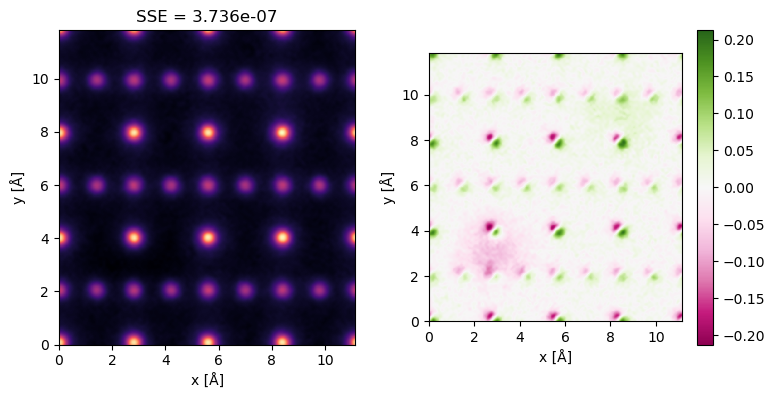

In [7]:
electrostatic_object = (forward_objects[-1].angle() + reverse_objects[-1].angle()) / 2
magnetic_object = (forward_objects[-1].angle() - reverse_objects[-1].angle()) / 2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

electrostatic_object.interpolate(electrostatic_potential.sampling).show(
    cmap="magma",
    ax=ax1,
    title=f"SSE = {float((forward_sse[-1]+reverse_sse[-1])/2):.3e}",
)

cmin_subtraction = np.amin(magnetic_object.array)

magnetic_object.interpolate(electrostatic_potential.sampling).show(
    cmap="PiYG", cbar=True, vmin=cmin_subtraction, vmax=-cmin_subtraction, ax=ax2
)

fig.tight_layout();

This doesn't work very well at all, since the magnetic vector potential is so much smaller compared to the electrostatic potential - and we are amplifying our noise by subtracting our two reconstructions.

Instead, we can use our knowledge of the forward models to modify our exit-wave and update-rule formulations to jointly-reconstruct both objects using two sets of diffraction patterns:

$$
\begin{aligned}
\psi_{j \boldsymbol{r}} &= P^{\psi}_{\boldsymbol{r}} \times V_{\boldsymbol{r}-\boldsymbol{R}_j} \times M_{\boldsymbol{r}-\boldsymbol{R}_j} \\
\phi_{j \boldsymbol{r}} &= P^{\phi}_{\boldsymbol{r}} \times V_{\boldsymbol{r}-\boldsymbol{R}_j} \times M^*_{\boldsymbol{r}-\boldsymbol{R}_j}
\end{aligned}
$$

In [8]:
from abtem.reconstruct import SimultaneousPtychographicOperator

simultaneous_reconstruction_ptycho_operator = SimultaneousPtychographicOperator(
    (measurement_forward, measurement_reverse),
    semiangle_cutoff=24,
    energy=200e3,
    device="gpu",
    parameters={"object_px_padding": (0, 0)},
).preprocess()

(
    simpie_objects,
    simpie_probes,
    simpie_positions,
    simpie_sse,
) = simultaneous_reconstruction_ptycho_operator.reconstruct(
    max_iterations=10,
    verbose=True,
    random_seed=1,
    common_probe=True,
    warmup_update_steps=simultaneous_reconstruction_ptycho_operator._num_diffraction_patterns
    * 5,
    return_iterations=True,
    parameters={
        "step_size_damping_rate": 0.75,
        "pure_phase_object_update_steps": simultaneous_reconstruction_ptycho_operator._num_diffraction_patterns
        * 5,
    },
)

Ptychographic reconstruction will perform the following steps:
--Regularized PIE for 11750 steps
--Simultaneous PIE for 11750 steps
--Probe correction is enabled
--Using the first probe as a common probe for both objects
--Reconstructed object will be constrained to a pure-phase object for the first 11750 steps


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

----Iteration 0 , SSE = 2.099e-06
----Iteration 1 , SSE = 4.782e-07
----Iteration 2 , SSE = 3.260e-07
----Iteration 3 , SSE = 2.939e-07
----Iteration 4 , SSE = 2.742e-07
----Iteration 5 , SSE = 2.417e-07
----Iteration 6 , SSE = 2.344e-07
----Iteration 7 , SSE = 2.310e-07
----Iteration 8 , SSE = 2.285e-07
----Iteration 9 , SSE = 2.269e-07


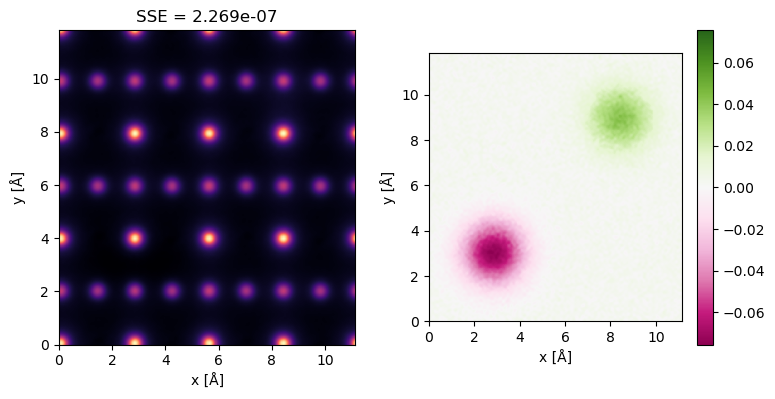

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

simpie_objects[-1][0].angle().interpolate(electrostatic_potential.sampling).show(
    cmap="magma", ax=ax1, title=f"SSE = {float(simpie_sse[-1]):.3e}"
)

cmin_common = np.amin(simpie_objects[-1][1].angle().array)

simpie_objects[-1][1].angle().interpolate(electrostatic_potential.sampling).show(
    cmap="PiYG", cbar=True, vmin=cmin_common, vmax=-cmin_common, ax=ax2
)

fig.tight_layout();

This indeed works significantly better!  
_Note:_ We improved the convergence and speed by taking Regularized-PIE `warmup_update_steps` and using a `common_probe` for both projections